In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

## Data Wrangling

In [2]:
from google.colab import files
uploaded = files.upload()

Saving S&P_transformed_17-20.csv to S&P_transformed_17-20.csv


In [4]:
data=pd.read_csv("S&P_transformed_17-20.csv")

In [5]:
data=data[65:]
data

,time,open,high,low,close,volume,close_change_$,close_change_%,volume_change,volume_change_%,sma_5_min,sma_8_min,sma_13_min,sma_5_bar,sma_8_bar,sma_13_bar,price_change_binary
65,7/28/17 10:34,246.260,246.300,246.2000,246.2600,222615,0.0000,0.000000,60335,37.179566,246.60100,246.665625,246.713077,246.691800,246.613802,246.538354,0
66,7/28/17 10:35,246.260,246.290,246.2257,246.2800,136025,0.0200,0.008121,-86590,-38.896750,246.59300,246.660625,246.716538,246.680400,246.604052,246.530662,1
67,7/28/17 10:36,246.290,246.365,246.2870,246.3600,119204,0.0800,0.032483,-16821,-12.366109,246.62500,246.681250,246.734231,246.677200,246.598928,246.526508,1
68,7/28/17 10:37,246.360,246.365,246.3300,246.3300,89515,-0.0300,-0.012177,-29689,-24.906043,246.66700,246.710000,246.748077,246.676000,246.595945,246.522662,0
69,7/28/17 10:38,246.330,246.380,246.3000,246.3150,151720,-0.0150,-0.006089,62205,69.491147,246.70500,246.742500,246.761154,246.674400,246.593945,246.519046,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323104,11/13/20 15:55,357.920,357.960,357.8100,357.8789,492569,-0.0411,-0.011483,102932,26.417409,357.35000,357.480838,357.522054,357.500748,357.480687,357.836252,0
323105,11/13/20 15:56,357.860,357.950,357.8000,357.8200,309294,-0.0589,-0.016458,-183275,-37.207985,357.44534,357.538338,357.544362,357.505148,357.506188,357.845791,0
323106,11/13/20 15:57,357.825,358.210,357.8118,358.2050,479111,0.3850,0.107596,169817,54.904718,357.53134,357.580837,357.564500,357.496948,357.530438,357.861098,1
323107,11/13/20 15:58,358.205,358.350,358.1400,358.3500,718921,0.1450,0.040480,239810,50.053119,357.62734,357.612087,357.589885,357.497348,357.553187,357.877252,1


In [ ]:
# # Flipping the dataset
# df = data[::-1].reset_index(drop=True)
# df

In [6]:
data=data[["open","high","low","close","volume"]]
data

,open,high,low,close,volume
65,246.260,246.300,246.2000,246.2600,222615
66,246.260,246.290,246.2257,246.2800,136025
67,246.290,246.365,246.2870,246.3600,119204
68,246.360,246.365,246.3300,246.3300,89515
69,246.330,246.380,246.3000,246.3150,151720
...,...,...,...,...,...
323104,357.920,357.960,357.8100,357.8789,492569
323105,357.860,357.950,357.8000,357.8200,309294
323106,357.825,358.210,357.8118,358.2050,479111
323107,358.205,358.350,358.1400,358.3500,718921


**Scaling the Data**

In [7]:
# Number of datapoints to use in predictions
history_points=390
# Value to predict (column index)
column=3

# Scaling data
MinMaxScaler = preprocessing.MinMaxScaler()
X = MinMaxScaler.fit_transform(data)

In [8]:
# Building normalised training data in segments of 390x5
# Get the normalised next day close data
historical_data_normalised =      np.array([X[i  : i + history_points].copy() for i in range(len(X) - history_points)])
next_day_close_values_normalised = np.array([X[:,column][i + history_points].copy() for i in range(len(X) - history_points)])
next_day_close_values_normalised = np.expand_dims(next_day_close_values_normalised, -1)

In [9]:
# Retriving the real next day open values
next_day_close_values = np.array([data.iloc[:,column][i + history_points].copy() for i in range(len(data) - history_points)])
# Expanding the dimentions of next_day_open_values_normalised (5246, 1, 1)
unscaled_y = np.expand_dims(next_day_close_values, -1)

In [10]:
y_normaliser = preprocessing.MinMaxScaler()
y_normaliser.fit(unscaled_y)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [12]:
assert historical_data_normalised.shape[0] == next_day_close_values_normalised.shape[0]

In [13]:
test_split = 0.9 # percent of data to be used for testing
n = int(historical_data_normalised.shape[0] * test_split)

# splitting the dataset up into train and test sets

X_train = historical_data_normalised[:n]
y_train = next_day_close_values_normalised[:n]

X_test = historical_data_normalised[n:]
y_test = next_day_close_values_normalised[n:]

unscaled_y_test = unscaled_y[n:]

In [14]:
# Viewing shape of input data
historical_data_normalised.shape

(322654, 390, 5)

In [16]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
import numpy as np
np.random.seed(4)
tf.random.set_seed(4)

lstm_input = Input(shape=(history_points, 5), name='lstm_input')
x = LSTM(390, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(64, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = Activation('linear', name='linear_output')(x)
model = Model(inputs=lstm_input, outputs=output)

adam = optimizers.Adam(lr=0.0005)

model.compile(optimizer=adam, loss='mse')

In [17]:
model.fit(X_train, y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)
evaluation = model.evaluate(X_test, y_test)
print(f"Test Loss:{evaluation}")

Epoch 1/50
8168/8168 [==============================] - 18274s 2s/step - loss: 1.2211e-04 - val_loss: 9.2274e-06
Epoch 2/50
 524/8168 [>.............................] - ETA: 4:43:58 - loss: 3.1927e-05

KeyboardInterrupt: ignored

In [ ]:
time_series=data["time"]
count=0
for time in time_series:
    if "11/11/20" in time:
        count+=1
print(f"Num of trading minutes per day: {count}")

history_points=count

Num of trading minutes per day: 390


In [ ]:
for i in range(len(X)-history_points):
    test=X[i  : i + history_points].copy()
    print(test.shape)
    break

(390, 5)


In [ ]:
# Building normalised training data in 1 day segments
historical_data_normalised = np.array([X[i  : i + history_points].copy() for i in range(len(X) - history_points)])
print(f"Individual Datapoint Shape: {historical_data_normalised[0].shape}")

Individual Datapoint Shape: (390, 5)


In [ ]:
# Get the normalised next day close data
next_day_close_values_normalised = np.array([X[:,3][i + history_points].copy() for i in range(len(X) - history_points)])
next_day_close_values_normalised = np.expand_dims(next_day_close_values_normalised, -1)
# 1st 'days' next day close value
next_day_close_values_normalised

array([[0.19535969],
       [0.19838001],
       [0.19886052],
       ...,
       [0.95939731],
       [0.96039264],
       [0.95867655]])

In [ ]:
# Displaying Second 'days' close number
historical_data_normalised[1][-1][3]

0.19535969247666118

In [ ]:
# Retriving the real next day open values
next_day_close_values = np.array([df.iloc[:,3][i + history_points].copy() for i in range(len(df) - history_points)])
# Expanding the dimentions of next_day_open_values_normalised (5246, 1, 1)
unscaled_y = np.expand_dims(next_day_close_values, -1)

In [ ]:
unscaled_y

array([[246.9  ],
       [247.34 ],
       [247.41 ],
       ...,
       [358.205],
       [358.35 ],
       [358.1  ]])

In [ ]:
y_normaliser = preprocessing.MinMaxScaler()
y_normaliser.fit(unscaled_y)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
assert historical_data_normalised.shape[0] == next_day_open_values_normalised.shape[0]
historical_data_normalised.shape

(322719, 390, 5)

**Creating final datasets**

In [ ]:
test_split = 2 # percent of data to be used for testing
n = int(historical_data_normalised.shape[0] * test_split)

# splitting the dataset up into train and test sets

X_train = historical_data_normalised[:n]
y_train = next_day_close_values_normalised[:n]

X_test = historical_data_normalised[n:]
y_test = next_day_close_values_normalised[n:]

unscaled_y_test = unscaled_y[n:]

## Buildling the Model

In [ ]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
import numpy as np
np.random.seed(4)
tf.random.set_seed(4)

lstm_input = Input(shape=(history_points, 5), name='lstm_input')
x = LSTM(390, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
x = Dense(64, name='dense_0')(x)
x = Activation('sigmoid', name='sigmoid_0')(x)
x = Dense(1, name='dense_1')(x)
output = Activation('linear', name='linear_output')(x)
model = Model(inputs=lstm_input, outputs=output)

adam = optimizers.Adam(lr=0.0005)

model.compile(optimizer=adam, loss='mse')

In [ ]:
model.fit(X_train, y_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)
evaluation = model.evaluate(X_test, y_test)
print(f"Test Loss:{evaluation}")

Epoch 1/50
  36/9077 [..............................] - ETA: 4:27:13 - loss: 0.0123

KeyboardInterrupt: 

**MSE of the normalized dataset**

In [ ]:
y_test_predicted = model.predict(X_test)
# # # model.predict returns normalised values
# # # now we scale them back up using the y_scaler from before
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)

# # # also getting predictions for the entire dataset, just to see how it performs
y_train_predicted = model.predict(X_train)
y_train_predicted = y_normaliser.inverse_transform(y_train_predicted)

# assert unscaled_y_test.shape == y_test_predicted.shape
real_mse = np.mean(np.square(unscaled_y_test - y_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_y_test) - np.min(unscaled_y_test)) * 100
print(f"Scaled MSE: {scaled_mse}")

Scaled MSE: 59.94620554085917


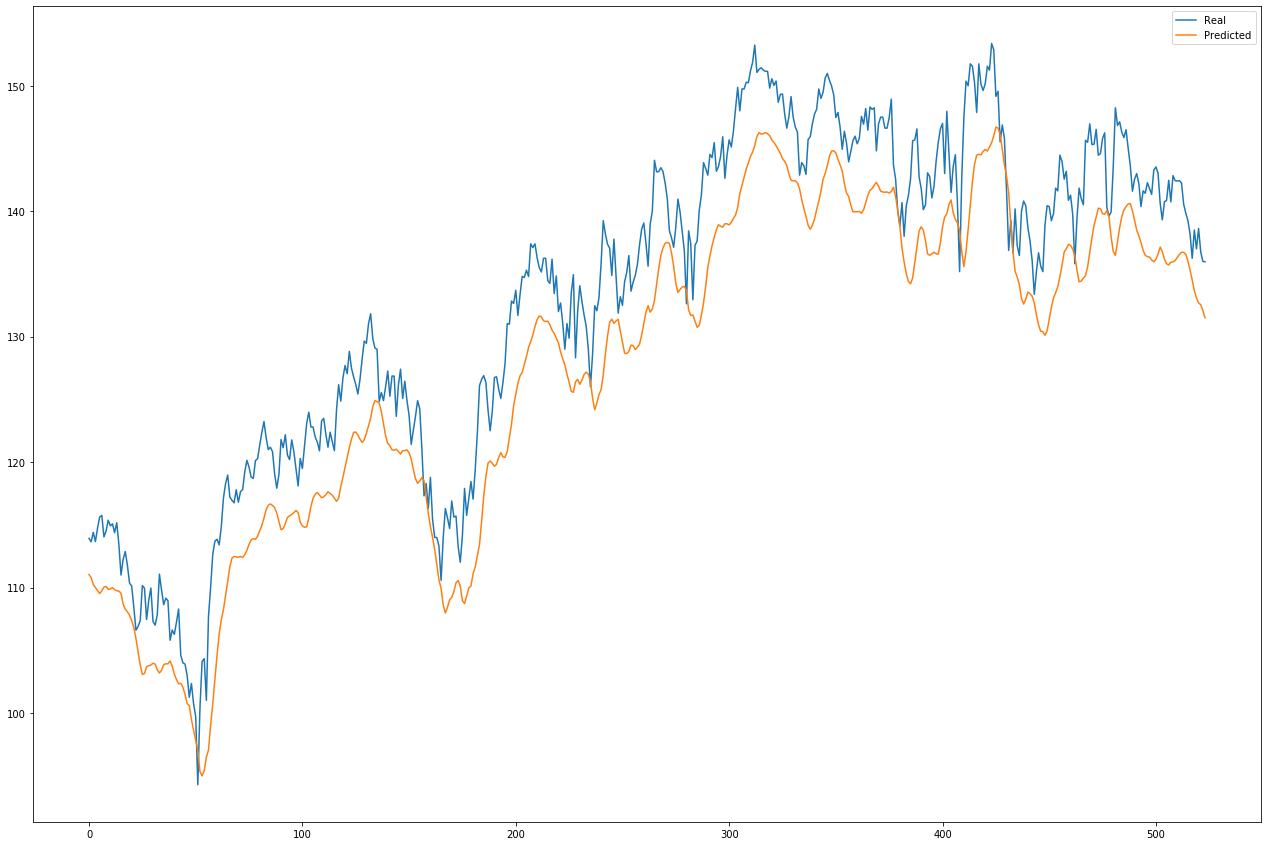

In [ ]:
import matplotlib.pyplot as plt
plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])

plt.show()

In [ ]:
model.predict()

## Trading Algorithm

In [ ]:
buys = []
sells = []
thresh = 0.2

x = 0
for x in X_test:
    normalised_price_today = x[-1][0]
    normalised_price_today = np.array([[normalised_price_today]])
    print(normalised_price_today)
#     price_today = y_scaler.inverse_transform(normalised_price_today)
#     print(price_today)
#     predicted = np.squeeze(y_scaler.inverse_transform(model.predict(np.expand_dims(x,0))))
    predicted = np.squeeze(model.predict(np.expand_dims(x,0)))
    print(predicted)
    delta = predicted - normalised_price_today
    print(f"Delta: {delta}")
    if delta > thresh:
        buys.append((x, normalised_price_today[0][0]))
    elif delta < -thresh:
        sells.append((x, normalised_price_today[0][0]))
    x += 1
print(buys)
print(sells)

[[4.16100263]]
2.961179
Delta: [[-1.19982362]]
[[1.15529356]]
1.2982707
Delta: [[0.14297714]]
[[1.15438146]]
1.295336
Delta: [[0.14095455]]
[[1.15691507]]
1.2937144
Delta: [[0.13679933]]
[[1.15441524]]
1.2922821
Delta: [[0.13786686]]
[[1.15806364]]
1.2913884
Delta: [[0.13332475]]
[[1.16103642]]
1.2926353
Delta: [[0.13159891]]
[[1.16147558]]
1.2939588
Delta: [[0.13248321]]
[[1.15569894]]
1.2937162
Delta: [[0.13801725]]
[[1.15725289]]
1.2925276
Delta: [[0.13527467]]
[[1.16019188]]
1.2927803
Delta: [[0.1325884]]
[[1.15867171]]
1.2931788
Delta: [[0.13450709]]
[[1.15921222]]
1.2926942
Delta: [[0.133482]]
[[1.15681373]]
1.2925739
Delta: [[0.1357602]]
[[1.15951625]]
1.2927033
Delta: [[0.13318702]]
[[1.15367205]]
1.2918538
Delta: [[0.13818174]]
[[1.14542936]]
1.2885187
Delta: [[0.1430893]]
[[1.14965205]]
1.2869323
Delta: [[0.1372803]]
[[1.1517465]]
1.2866335
Delta: [[0.13488699]]
[[1.14803054]]
1.2858235
Delta: [[0.13779293]]
[[1.14323357]]
1.2844138
Delta: [[0.14118025]]
[[1.14245659]]
1.2822

1.288616
Delta: [[0.13244406]]
[[1.1687386]]
1.2914761
Delta: [[0.12273753]]
[[1.16150936]]
1.294104
Delta: [[0.13259462]]
[[1.16613742]]
1.296906
Delta: [[0.13076857]]
[[1.17059658]]
1.3007367
Delta: [[0.13014008]]
[[1.16586717]]
1.3027893
Delta: [[0.13692216]]
[[1.17380582]]
1.306034
Delta: [[0.13222814]]
[[1.18373759]]
1.3089206
Delta: [[0.12518304]]
[[1.19643943]]
1.3159214
Delta: [[0.119482]]
[[1.1981285]]
1.3232429
Delta: [[0.1251144]]
[[1.19914195]]
1.328006
Delta: [[0.12886408]]
[[1.19728397]]
1.3305881
Delta: [[0.13330414]]
[[1.18985204]]
1.3292994
Delta: [[0.13944741]]
[[1.18427809]]
1.3269447
Delta: [[0.14266662]]
[[1.18951422]]
1.3252274
Delta: [[0.13571316]]
[[1.19863523]]
1.3255429
Delta: [[0.1269077]]
[[1.19880413]]
1.3276019
Delta: [[0.12879777]]
[[1.19542598]]
1.3290176
Delta: [[0.13359165]]
[[1.19299372]]
1.3277931
Delta: [[0.1347994]]
[[1.19728397]]
1.3281364
Delta: [[0.13085248]]
[[1.2025201]]
1.330054
Delta: [[0.12753394]]
[[1.21312749]]
1.3344913
Delta: [[0.121363

1.3927059
Delta: [[0.13094151]]
[[1.25669718]]
1.3906902
Delta: [[0.13399302]]
[[1.25944193]]
1.38928
Delta: [[0.12983803]]
[[1.26239781]]
1.390044
Delta: [[0.12764616]]
[[1.26361158]]
1.3906423
Delta: [[0.12703071]]
[[1.26155327]]
1.391183
Delta: [[0.12962975]]
[[1.26303121]]
1.3908303
Delta: [[0.12779906]]
[[1.26894298]]
1.3922862
Delta: [[0.1233432]]
[[1.26683163]]
1.3946698
Delta: [[0.12783814]]
[[1.27105432]]
1.3970461
Delta: [[0.12599177]]
[[1.26524796]]
1.3983169
Delta: [[0.1330689]]
[[1.27147659]]
1.398623
Delta: [[0.1271464]]
[[1.27084319]]
1.3993999
Delta: [[0.12855669]]
[[1.27126546]]
1.3999252
Delta: [[0.12865978]]
[[1.25965306]]
1.3981823
Delta: [[0.13852921]]
[[1.26693703]]
1.3962433
Delta: [[0.1293063]]
[[1.26873184]]
1.3958042
Delta: [[0.12707232]]
[[1.26873184]]
1.3957344
Delta: [[0.12700259]]
[[1.26577596]]
1.3958067
Delta: [[0.13003071]]
[[1.26577596]]
1.395575
Delta: [[0.12979909]]
[[1.26862611]]
1.3963442
Delta: [[0.12771808]]
[[1.27358793]]
1.3981097
Delta: [[0.12

IndexError: list index out of range

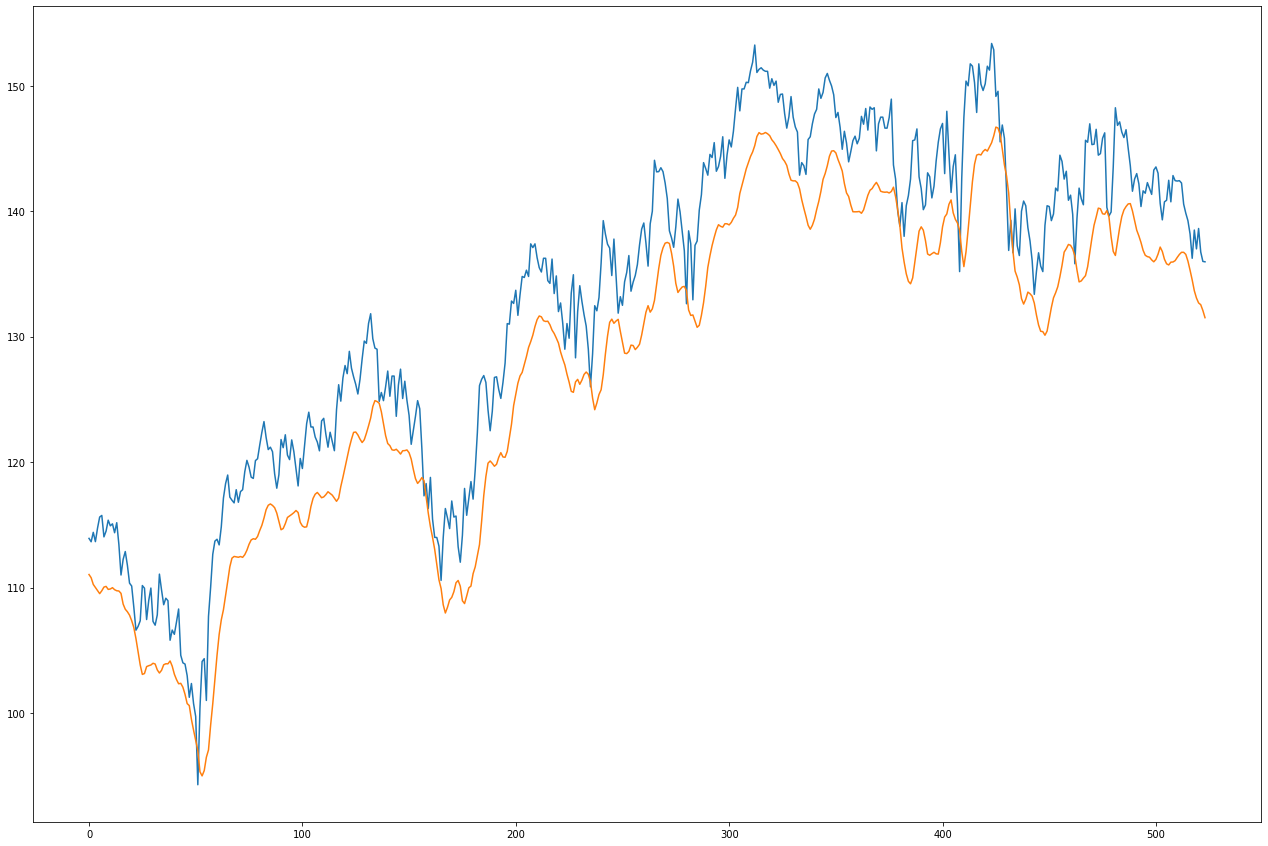

In [ ]:
import matplotlib.pyplot as plt

plt.gcf().set_size_inches(22, 15, forward=True)

start = 0
end = -1

real = plt.plot(unscaled_y_test[start:end], label='real')
pred = plt.plot(y_test_predicted[start:end], label='predicted')

plt.scatter(list(list(zip(*buys))[0]), list(list(zip(*buys))[1]), c='#00ff00')
plt.scatter(list(list(zip(*sells))[0]), list(list(zip(*sells))[1]), c='#ff0000')

# real = plt.plot(unscaled_y[start:end], label='real')
# pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])

plt.show()

In [ ]:
def compute_earnings(buys, sells):
    purchase_amt = 10
    stock = 0
    balance = 0
    while (len(buys) > 0) and (len(sells) > 0):
        if buys[0][0] < sells[0][0]:
            # time to buy $10 worth of stock
            balance -= purchase_amt
            stock += purchase_amt / buys[0][1]
            buys.pop(0)
        else:
            # time to sell all of our stock
            balance += stock * sells[0][1]
            stock = 0
            sells.pop(0)
    print(balance)

In [ ]:
compute_earnings(buys, sells)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()